# 1. softmax回归的简洁实现

通过深度学习框架的高级API能够使实现softmax回归变得更容易

In [1]:
import torch 
from torch import nn
import d2l_torch as d2l

batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

In [19]:
# 参见额外扩展中->代码中的flatten验证部分说明
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        # 使用正态分布对某个层进行初始化，mean默认为0，std默认为1
        print(m.weight[:5,:5],m.weight.shape)
net.apply(init_weights)
# 对调用者的每个子模块应用函数，最典型的使用就是模型初始化的时候

tensor([[-0.0219,  0.0039, -0.0129, -0.0200,  0.0025],
        [ 0.0100, -0.0046,  0.0154,  0.0221,  0.0051],
        [-0.0173,  0.0083, -0.0095,  0.0031, -0.0036],
        [-0.0007, -0.0084,  0.0089, -0.0003, -0.0269],
        [ 0.0149,  0.0063,  0.0019,  0.0121,  0.0053]],
       grad_fn=<SliceBackward>) torch.Size([10, 784])


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

可以看到，`Linear`网络的输入输出是784\*10，刚好和`Linear`的weight形状10\*784是对称的。

In [3]:
# 参考 额外扩展 -> pytorch中的CrossEntropyLoss
# 在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数。
loss=nn.CrossEntropyLoss()

In [4]:
# 使用学习率为0.1的小批量随机梯度下降作为优化算法
# 参考 额外扩展->SGD
trainer=torch.optim.SGD(net.parameters(),lr=0.1)

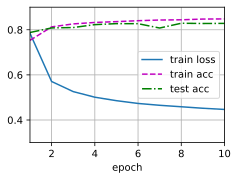

In [5]:
# 然后可以直接调用之前定义的训练函数来训练模型
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

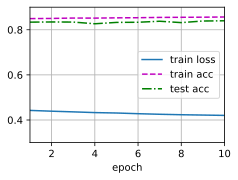

In [6]:
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

可以看到，和之前情况差不多，不重新将参数初始化，那么这里训练的时候，W和b就还都是基于上次训练之后的结果进行的。

可以看看 额外扩展中 网络参数 初始化 训练后

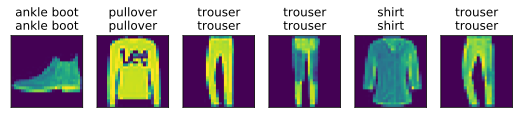

In [25]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## y是否需要是one-hot？

In [27]:
net(X[0:3])
# 可以看到，每个样本的输出都是一个对应10个类别的一维向量

tensor([[ -4.1669,  -5.7686,  -3.9745,  -3.8019,  -4.7230,   4.2486,  -2.8334,
          10.8520,   0.4810,   8.8874],
        [  1.2168,  10.5518,   0.5413,   6.2306,   2.7688, -13.0822,  -2.8121,
          -0.8452,  -2.5705,  -2.1171],
        [  2.6795,   0.9074,   9.4938,   0.5538,   6.1619,  -9.1349,   7.5568,
         -11.8593,   1.0910,  -7.9913]], grad_fn=<AddmmBackward>)

In [29]:
for X, y in test_iter:
    print(y[:30])
    break

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3])


但是很明显，这里输入的y每个都只有标签，所以要将这个转换成 one-hot编码？？

In [30]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

可以看到，
+ 在简洁实现中，对于损失函数求概率来说，正确标签对应的概率就是要进行优化的目标。。。不需要它是one-hot
+ 在使用pytoch自带的实现中，很明显，在调用的时候也没有对y进行one-hot，查看源代码
    + 下面是给出的crossEntropyLoss的示例，可以看到，输入是三个样本，target是对应于三个样本的三个值。
    + 函数对于shape的说明：
     input：(N,C) C=类别数量 N一般是batch_size中样本的数量
     target:N 其中N个元素的每个值都在[0,C-1]之间，
     output：当`reduction`为`none`时，输出维度和target的相同，都为N
     
**结论**

>对于softmax分类问题（使用cross_entropy_loss）来说，不需要对y进行one-hot

In [32]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
output = loss(input, target)
output.backward()
print(output)

tensor([[ 0.1012, -1.6809,  0.3797,  0.7783, -1.7213],
        [ 0.4773,  0.9476,  1.6059, -0.0070, -0.9030],
        [ 1.1288, -0.3880, -0.7008,  0.1444, -2.0975]], requires_grad=True)
tensor([1, 1, 3])
tensor(2.0971, grad_fn=<NllLossBackward>)


## **总结**

简洁实现和从0实现之间的对应关系

|简洁实现|从0实现|作用|
|---|---|---|
|nn.Flatten() |reshape |将输入数据变成二维的|
|init_weights()| 对W和b赋值|初始化|
|CrossEntropyLoss|-torch.log(softmax())|加入-log的softmax作为损失函数|
|net.parameter()|[W,b]|向优化器传参，一个是直接调参数，一个是直接写上去|

另外，
+ 在简介实现中，net只是一个单纯的Linear网络，y=ax+b的这种，损失函数是logsoftmax+NLLloss，可以表示为：
    + $$ loss(x,class)=-log(\frac{exp(x[class])}{\sum_{j}{exp_j}})$$
+ 而在从0的实现中，
    + net是 `softmax(torch.matmul(X.reshape(-1,W.shape[0]),W) + b)`,
    + 损失是 `torch.log(y_hat[range(len(y_hat)),y])`
    
+ 从理解的角度来说，针对使用softmax分类问题，建模我个人觉得应该建成从0实现中那个样子，比较符合建模理解

# 额外扩展

## 代码中的flatten()验证

In [9]:
for X,y in train_iter:
    print(X.shape)
    break

torch.Size([256, 1, 28, 28])


softmax回归的 输出层 是一个全连接层。

+ 由于pytorch不会隐式的帮助我们调整输入的形状
+ 因此，定义展平层(flatten)在线性层前调整网络输入的形状
+ flatten的作用是把输入的任意维度的tensor变成一个2d的tensor，其中输入tensor的第0维保留，剩下的维度全部展成一个向量。
    + 函数说明中：Args:
        + start_dim: first dim to flatten (default = 1).
        + end_dim: last dim to flatten (default = -1).
    + 这个flatten就对应softmax从头实现里的reshape函数
+ train_iter中每个batch的size如上，其实是256个 通道数为1，大小为28\*28的图像
+ 但是由于Linear网络层接收的输入输出只能是一维的，所以使用Flatten压扁，变成256\*784，如下

In [12]:
for X,y in train_iter:
    m = nn.Sequential(nn.Flatten())
    output = m(X)
    print(output.size())
    break

torch.Size([256, 784])


## flatten()和conv2d()函数

关于flatten()，可以看下面这个例子
+ 输入是32个1通道 5\*5的图像
+ 使用的2d卷积，
    + `in_channel`=1,
    + `out_channels`=32
    + `kernel_size`=5\*5
    + `stride` = 1,
    + `padding`= 1,

In [2]:
input = torch.randn(32, 1, 5, 5)
m = nn.Sequential(
    nn.Conv2d(1, 32, 5, 1, 1),
    nn.Flatten()
)
output = m(input)
output.size()

torch.Size([32, 288])

288=32\*3\*3

In [6]:
input = torch.randn(32, 1, 5, 5)
m = nn.Sequential(nn.Conv2d(1, 32, 5, 1, 1))
output = m(input)
output.size()

torch.Size([32, 32, 3, 3])

## pytorch中的CrossEntropyLoss

从0实现中，是cross_entropy调用了softmax。而pytorch对于交叉熵损失函数的实现是：
[torch.nn.CrossEntropyLoss.html](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

简单来说，pytorch的`CrossEntropyLoss`实现组合了`LogSoftmax` 和`NLLLoss` 在一个类中
+ 其中`LogSoftmax`的公式就是：

$$log\frac{exp(x_i)}{\sum_{j}{exp(x_j)}}$$

+ 而NLLloss，就是 The negative log likelihood loss. 负log似然损失

最开始学习梯度下降的时候，知道有 
+ BGD 批量梯度下降 一次计算所有数据的梯度 用来更新
+ SGD 随机梯度下降，每次随机选一个样本，更新梯度
+ MBGD 小批量梯度下降，Mini-Batch 每次使用一个batch的数据进行更新，但是batch数据产生是随机的，但是batch之间其实是有序的。

参考：[pytorch中torch.optim.SGD的step()怎么实现随机取样本计算梯度以减少运算量？](https://ask.csdn.net/questions/7398069)

可知：
+ SGD随机梯度下降本质是只取一个样本来计算梯度，避免了梯度下降用全部样本计算梯度的大量运算，而在上面的代码里的loss.backward()会使用全部样本来计算梯度，那么optimizer.step()又怎么来随机取样本呢
+ 现在的主流框架中所谓的SGD实际上都是Mini-batch Gradient Descent (MBGD，亦成为SGD）。对于含有N个训练样本的数据集，每次参数更新，仅依据一部分数据计算梯度。小批量梯度下降法既保证了训练速度，也保证了最后收敛的准确率。
+ 随机取样本不在优化器中进行，优化器只负责计算所有参数对应的梯度。取样本是在每次迭代时获取的。

```python

for epoch in range(N):
    optimizer.zero_grad()
    output = model(input)
```

实际上这里更详细的操作应该是这样的：

```python
for epoch in range(N):
    for batch in data_loader:  # <== 随机获取一部分数据是由你构造的data_loader实现的
        optimizer.zero_grad()
        output = model(batch)  # <== 此处输入即为随机的一部分数据
```

所以如果data_loader中的batch_size是1，其实就是SGD了。所以数据随机部分体现在构造数据batch的时候，即SGD是MBGD的一种特殊情况

参考：
+ [相关-4.批量梯度下降(BGD)、随机梯度下降(SGD)和小批量梯度下降(MBGD)](https://blog.csdn.net/Castlehe/article/details/119351889)
+ SGD源代码：https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD
+ 或者直接去github上看源代码：https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py
    + 其中涉及到几个`F.sgd`:https://github.com/pytorch/pytorch/blob/master/torch/optim/_functional.py#L146:5
    + 继承的父类 Optimizer: https://github.com/pytorch/pytorch/blob/master/torch/optim/optimizer.py#L18:7

## 网络参数（初始化 训练后）

查看一下网络的参数，观察一下net.parameters() 

根据：https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html

```bash
Parameters
data (Tensor) – parameter tensor.

requires_grad (bool, optional) – if the parameter requires gradient. See Locally disabling gradient computation for more details. Default: True
```

In [7]:
net.parameters()

<generator object Module.parameters at 0x000001790DBF7248>

In [16]:
for param in net.parameters():
    print(type(param), param.size(),param.grad)
# 还可以使用param.data查看参数的数值

<class 'torch.nn.parameter.Parameter'> torch.Size([10, 784]) tensor([[ 0.0000e+00,  5.1238e-07,  8.3734e-07,  ...,  3.4898e-04,
         -1.7889e-05,  0.0000e+00],
        [ 0.0000e+00,  3.5646e-09,  9.0764e-09,  ...,  6.1902e-04,
          2.3446e-07,  0.0000e+00],
        [ 0.0000e+00,  7.6087e-07, -2.9371e-06,  ..., -7.7704e-04,
          7.6416e-06,  0.0000e+00],
        ...,
        [ 0.0000e+00,  2.3418e-11,  3.3827e-11,  ...,  1.1083e-05,
          3.8960e-06,  0.0000e+00],
        [ 0.0000e+00, -2.0158e-05, -2.9020e-05,  ..., -5.6437e-03,
          3.1445e-05,  0.0000e+00],
        [ 0.0000e+00,  7.6280e-08,  1.1018e-07,  ...,  2.0563e-04,
          7.2272e-05,  0.0000e+00]])
<class 'torch.nn.parameter.Parameter'> torch.Size([10]) tensor([ 0.0143,  0.0121,  0.0149, -0.0283,  0.0077, -0.0043,  0.0041, -0.0035,
        -0.0222,  0.0053])


如果想看网络中每层的参数，需要了解一下 这个模型

可以看到，这里打印输出的W的参数值，和初始化时候看到的Linear的权重w打印出的值已经不一样了

## Pytorch nn.Module模块详解

参考： https://pytorch.org/docs/stable/nn.html#containers

可以看到这个组织形式

In [35]:
type(net)

torch.nn.modules.container.Sequential


pytorch的model以Containers形式组织的，下面都是containers的实现形式

|object|说明|备注|
|---|---|---|
|Module |Base class for all neural network modules.|是所有神经网络模块的基类|
|Sequential|A sequential container.|序列容器|
|ModuleList|Holds submodules in a list.|各个网络层放在一个列表中|
|ModuleDict|Holds submodules in a dictionary.|各个网络层放在一个字典中|
|ParameterList|Holds parameters in a list.|参数列表|
|ParameterDict|Holds parameters in a dictionary.|参数字典|

使用字典和列表这两种形式，个人猜测是有序和无序的区别。

关于**Module**模块：
> Base class for all neural network modules.
Your models should also subclass this class.

所以使用torch.nn构建的模型，都可以使用Module这个class的方法，https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module

如果想更好了解的话，参考：
+ [【pytorch】torch.nn 模块笔记](https://www.cnblogs.com/ytxwzqin/p/12760956.html)
+ [pytorch教程之nn.Module类详解——使用Module类来自定义网络层](https://blog.csdn.net/qq_27825451/article/details/90705328)
+ [Pytorch nn.Module模块详解](https://blog.csdn.net/weixin_42018112/article/details/90084419)

### sequential model查看网络层

In [18]:
for submodule in net.children():
    print(submodule)

Flatten(start_dim=1, end_dim=-1)
Linear(in_features=784, out_features=10, bias=True)


In [21]:
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        # 使用正态分布对某个层进行初始化，mean默认为0，std默认为1
#         print(m.weight[:5,:5],m.weight.shape)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

可以看到，查看网络结构，可以用children()方法，返回一个迭代器。结果和应用apply返回的module self是一样的

In [23]:
net.cpu()
# 查看函数说明 这个函数返回的内容和apply一样，都是model self

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [37]:
net[0]

Flatten(start_dim=1, end_dim=-1)

瞎倒腾，发现其实可以这样看net的每一层。。。炫酷

In [38]:
net

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

直接打印，也会显示网络结构

### state_dict查看训练过程中参数变化

参考：[【PyTorch】state_dict详解](https://blog.csdn.net/bigFatCat_Tom/article/details/90722261)

输出结果类似：

```bash
Model.state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer,s state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [367949288, 367949432, 376459056, 381121808, 381121952, 381122024, 381121880, 381122168, 381122096, 381122312]}]
```